##### Numerical solving of the transfer equation

We consider an 1-dimensional partial differential transfer equation of the first order 
$$ u_t + a u_x = 0 $$ on the interval $ t > 0, 0 < x < 1 $ 
with boundary conditions $$ u(0, t) = \mu(t) $$
                         $$ u(x, 0) = u_0(x) $$

In [168]:
import numpy as np
import matplotlib.pyplot as plt

# Initial condition functions
start = 0.2
stop = 0.8
height = 1

def u1(x):
    if x >= start and x <= stop:
        return np.sin((x - start) * np.pi / (stop - start)) ** 2
    else:
        return 0

def u2(x):
    if x > start and x < stop:
        return height
    else:
        return 0

def u3(x):
    if x <= start:
        return height
    else:
        return 0

def u4(x):
    if x >= stop:
        return height
    else:
        return 0

def mu0(t):
    return 0

def mu1(t):
    return height

def real(f, x, t, a):
    N = len(x)
    y = np.zeros(N)
    for i in range(len(x)):
        y[i] = f(x[i] - a*t)
    return y

## 1. Explicit left corner

Firstly we split our intervals and make a 2-dimensional grid:  
$ t \in [0,T] $ with step $ \tau = \frac{T}{M} $  
$ x \in [0,1] $ with step $ h = \frac{1}{N} $  

Let's make a difference scheme with first order of approximation of first derivatives:
$$ \frac{u_i^{j+1} - u_i^j}{\tau} + a \frac{u_i^j - u_{i-1}^j}{h} = 0 $$
where index $ i \in [0, N] $ - space index and $ j \in [0, M] $ - time index  
The stencil: $$  ~~~~~~~~~~~~~~    * $$
             $$  ~~~~~~~~~~~~~~    | $$
             $$  *---* $$
If define the Courant number as $ C = \frac{a \tau}{h} $, we can get the sufficient sign of stability: $ C < 1 $
$$ u_i^{j+1} =  u_i^j - C(u_i^j - u_{i-1}^j)$$

In [169]:
def explLeftCorner(u0, mu, x, t, a):
    N = len(x)
    M = len(t)
    h = x[1] - x[0]
    tau = t[1] - t[0]
    U = np.zeros((M, N))
    #start space
    for i in range(N):
        U[0][i] = u0(x[i])
        
    #start time
    for j in range(M-1):
        U[j+1][0] = mu(t[j+1])
        for i in range(1, N):
            U[j+1][i] = U[j][i] - tau*a*(U[j][i] - U[j][i-1])/h
    return U

T = 10
N = 100
M = 100
h = 1 / N
# h = 0.09
tau = T / M
# tau = 0.09
x = np.linspace(0, 1, N)
t = np.linspace(0, T, M)
a = 0.05

courant = a * tau / h
print("Courant number: ", courant)

res1 = explLeftCorner(u1, mu0, x, t, a)
res2 = explLeftCorner(u2, mu0, x, t, a)
res3 = explLeftCorner(u3, mu1, x, t, a)
res4 = explLeftCorner(u4, mu0, x, t, a)

Courant number:  0.5000000000000001


In [186]:
from matplotlib import animation
def AnimationFunc(func, res, name, frame=50):
    ### Animation 

    # First set up the figure, the axis, and the plot element we want to animate
    fig = plt.figure()
    ax = plt.axes(xlim=(0, 1), ylim=(0, 1.2))

    lines=[]     # list for plot lines for solvers and analytical solutions
    legends=[]   # list for legends for solvers and analytical solutions

    line, = ax.plot([], [])
    lines.append(line)
    legends.append('Solved')

    line, = ax.plot([], []) #add extra plot line for analytical solution
    lines.append(line)
    legends.append('Analytical')

    plt.xlabel('x-coordinate')
    plt.ylabel('Amplitude')
    plt.legend(legends, loc=3, frameon=False)

    # initialization function: plot the background of each frame
    def init():
        for line in lines:
            line.set_data([], [])
        return lines,

    def animate_alt(i):
        for k, line in enumerate(lines):
            if (k==len(lines)-1):
                line.set_data(x, real(func, x, i, a/10))
            else:
                line.set_data(x, res[i])
        return lines,


    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate_alt, init_func=init, frames=frame, blit=False)
    anim.save(f'animation_transfer_{name}.gif', fps=25)

    plt.show()

def init(func):
    init_i = []
    for i in range(N):
        init_i.append(func(x[i]))
    return init_i

def CreateGraph(num, init, func):
    plt.figure(num)
    for i in range(M - 1):
        plt.plot(x, func[i])
    plt.plot(x, init, label='Initial')
    plt.plot(x, func[-1], label='end')
    plt.grid()
    plt.legend()


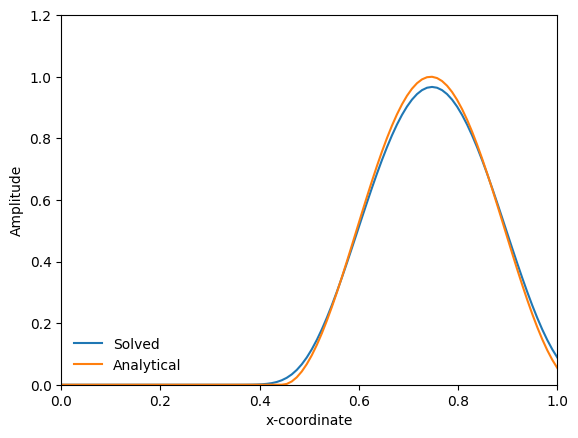

In [171]:
AnimationFunc(u1, res1, "explicit")

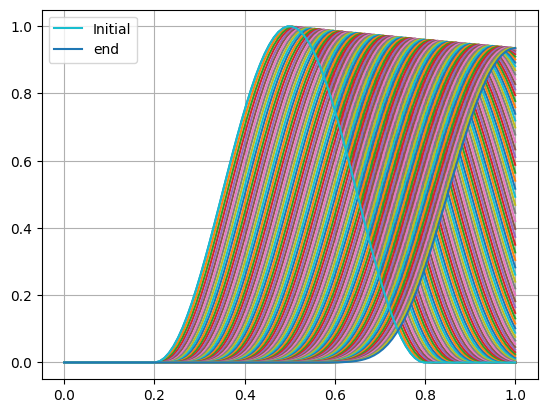

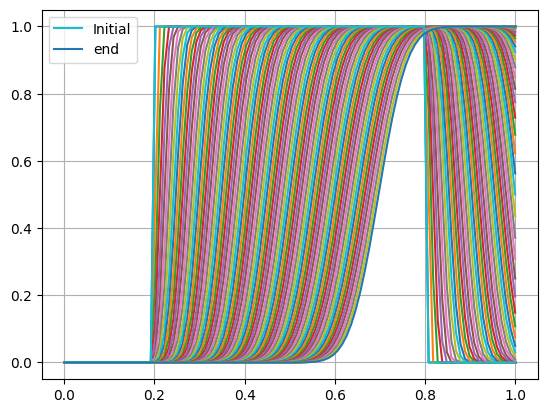

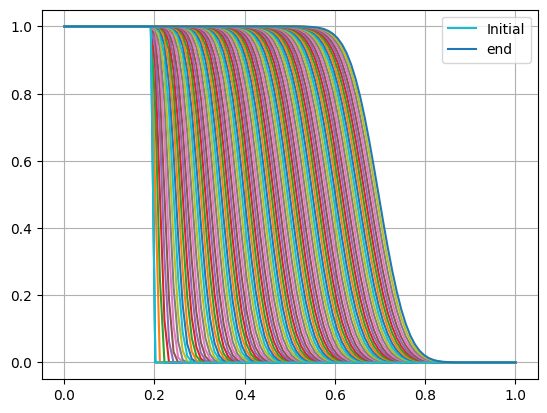

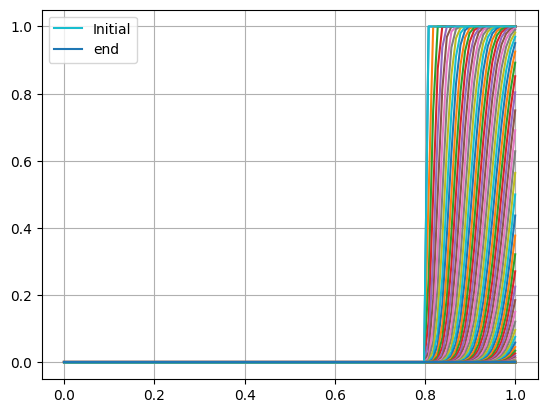

In [172]:
init1 = init(u1)
init2 = init(u2)
init3 = init(u3)
init4 = init(u4)

CreateGraph(1, init1, res1)
CreateGraph(2, init2, res2)
CreateGraph(3, init3, res3)
CreateGraph(4, init4, res4)
plt.show()

## 1.2 Approximation

Order of approximation =  -0.7805630899444164


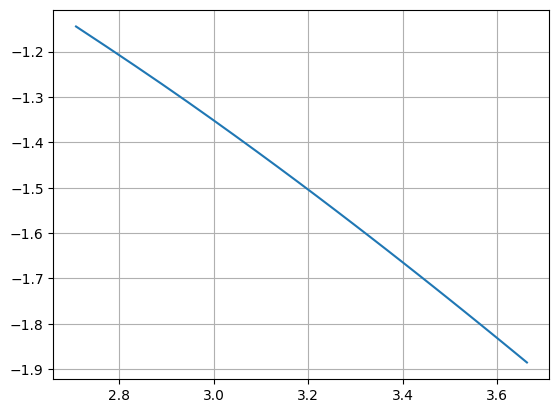

In [173]:
def Create_aprox_graph(func1, func2):
    index = np.log([x for x in range(start_range, end_range)])
    value = np.log([max(np.abs(explLeftCorner(u1, mu0, np.linspace(0, 1, i), np.linspace(0, T, i), a)[-1] - 
                               real(u1, np.linspace(0, 1, i), T, a)))
                    for i in range(start_range, end_range)])
    a1, b1 = np.polyfit(index, value, 1)
    print("Order of approximation = ", a1)
    plt.plot(index, value)
    
start_range = 15
end_range = 40

plt.figure()
Create_aprox_graph(u1, mu0)
plt.grid()
plt.show()

## 2. Implicit left corner

Let's make a difference scheme with first order of approximation of first derivatives:
$$ \frac{u_i^{j+1} - u_i^j}{\tau} + a \frac{u_i^{j+1} - u_{i-1}^{j+1}}{h} = 0 $$
where index $ i \in [0, N] $ - space index and $ j \in [0, M] $ - time index  
The stencil: $$  *---* $$
             $$  ~~~~~~~~~~~~~~    | $$
             $$  ~~~~~~~~~~~~~~    * $$
             
If define the Courant number as $ C = \frac{a \tau}{h} $, we can get the sufficient sign of stability: $ C > 0, C \le -1 $
$$ (u_i^{j+1} - u_i^j) + C(u_i^{j+1} - u_{i-1}^{j+1}) = 0 $$

In [174]:
def implLeftCorner(u0, mu, x, t, a):
    N = len(x)
    M = len(t)
    h = x[1] - x[0]
    tau = t[1] - t[0]
    U = np.zeros((M, N))
    C = a*tau/h
    for i in range(N):
        U[0][i] = u0(x[i])
    
    for j in range(M):
        U[j][0] = mu(t[j])
    
    for j in range(M - 1):
        for i in range(1, N):
            U[j+1][i] = U[j+1][i - 1]*C/(1 + C) + U[j][i]/(1 + C)
    return U

T = 10
N = 100
M = 100
h = 1 / N
tau = T / M
x = np.linspace(0, 1, N)
t = np.linspace(0, T, M)
a = 0.1

courant = a * tau / h
print("Courant number: ", courant)

res1 = implLeftCorner(u1, mu0, x, t, a)
res2 = implLeftCorner(u2, mu0, x, t, a)
res3 = implLeftCorner(u3, mu1, x, t, a)
res4 = implLeftCorner(u4, mu0, x, t, a)

Courant number:  1.0000000000000002


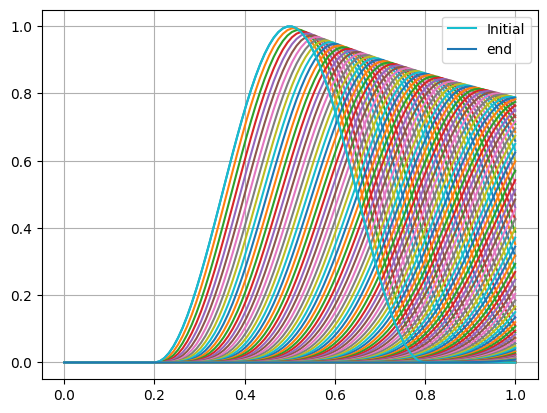

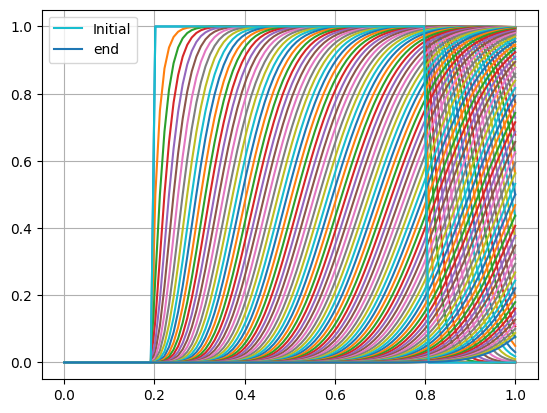

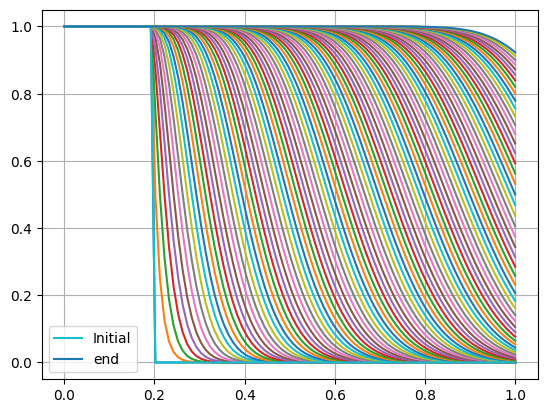

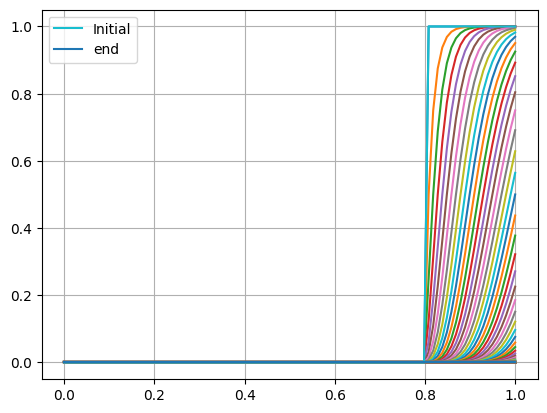

In [175]:
init1 = init(u1)
init2 = init(u2)
init3 = init(u3)
init4 = init(u4)

CreateGraph(1, init1, res1)
CreateGraph(2, init2, res2)
CreateGraph(3, init3, res3)
CreateGraph(4, init4, res4)
plt.show()

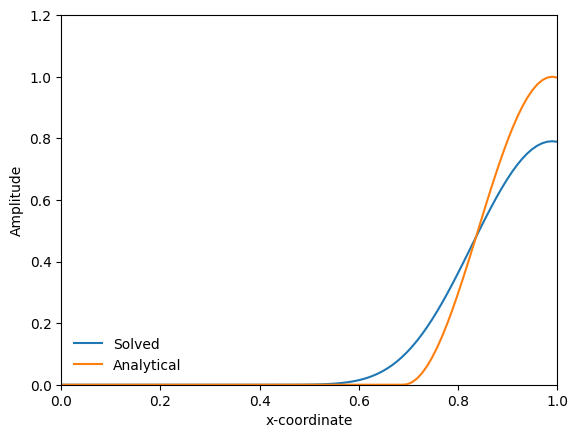

In [176]:
AnimationFunc(u1, res1, "implicit")

## 2.2 Approximation

Order x of approximation =  -1.442983942512892


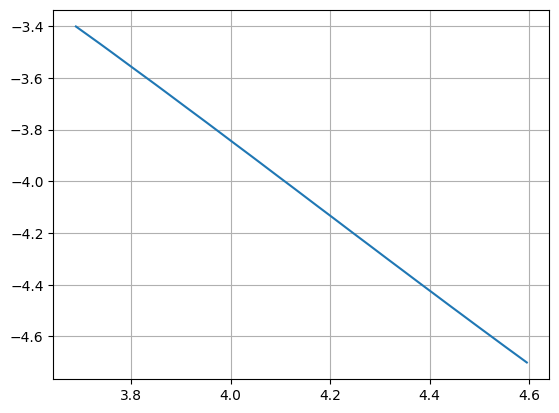

Order of t approximation =  -1.067808814392427


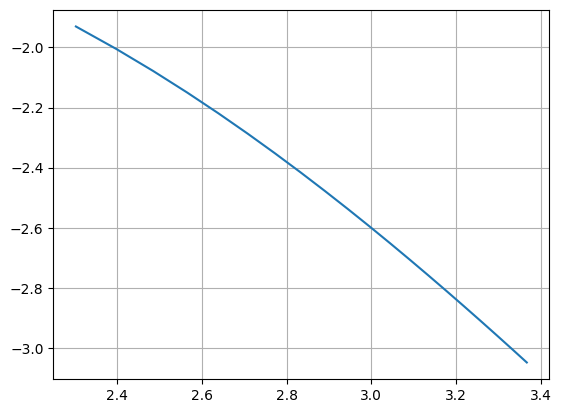

In [177]:
start_range = 40
end_range = 100

plt.figure()
index = np.log([i for i in range(start_range, end_range)])
value = np.log([max(np.abs(implLeftCorner(u1, mu0, np.linspace(0, 1, i), np.linspace(0, T, M), a)[-1] -
                        real(u1, np.linspace(0, 1, i), T, a))) for i in range(start_range, end_range)])
a1, b1 = np.polyfit(index, value, 1)
print("Order x of approximation = ", a1)
plt.plot(index, value)
plt.grid()
plt.show()

start_range2 = 10
end_range2 = 30
N2 = 100
plt.figure(2)
index = np.log([i for i in range(start_range2, end_range2)])
value = np.log([max(np.abs(implLeftCorner(u1, mu0, np.linspace(0, 1, N2), np.linspace(0, T, i), a)[-1]-
                        real(u1, np.linspace(0, 1, N2), T, a))) for i in range(start_range2, end_range2)])
a2, b2 = np.polyfit(index, value, 1)
print("Order of t approximation = ", a2)
plt.plot(index, value)
plt.grid()
plt.show()
#  1, 1

## 3. Lax-Wendroff scheme

![Lax3](Lax3.png)

![Lax2](Lax2.png)

![Error](Error_Lax.png)

Lax-Wendroff scheme is a composition of 2 schemes: Lax scheme and the cross scheme.  
1) We count values $u_L$ and $u_R$ on the $(i+1/2) $ time layer with using Lax scheme:
$$ \frac{u_L - 1/2 (u_{i-1}^j + u_i^j)}{\tau/2} + a \frac{u_i^j - u_{i-1}^j}{h} = 0 $$
$$ \frac{u_R - 1/2 (u_{i+1}^j + u_i^j)}{\tau/2} + a \frac{u_{i+1}^j - u_{i}^j}{h} = 0 $$
with the stencil: $$      * $$
                  $$      | $$
                  $$  *---* $$

2) We use the cross scheme with points $ u_L, u_R, u_i^j, u_i^{j+1} $:
$$ \frac{u_i^{j+1} - u_i^j}{\tau^2} + a \frac{u_R - u_L}{h^2} = 0 $$
with the stencil: $$      * $$
                  $$      | $$
                  $$    *---*   $$
                  $$      | $$
                  $$      * $$

In the sum we have the next stencil:
$$ * $$
$$ | $$
$$  x---x $$
$$ | $$
$$  *---*---* $$

Courant number:  0.5000000000000001


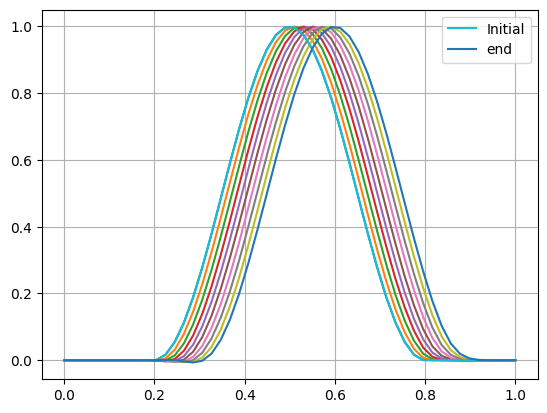

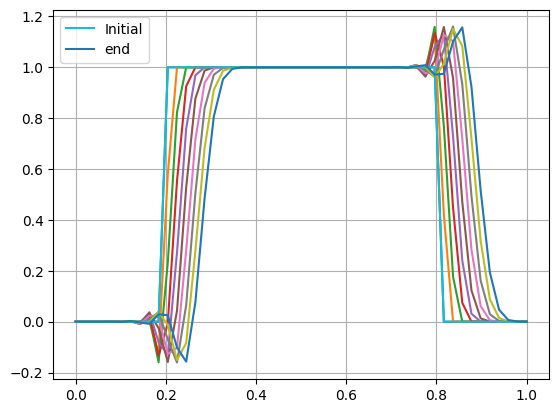

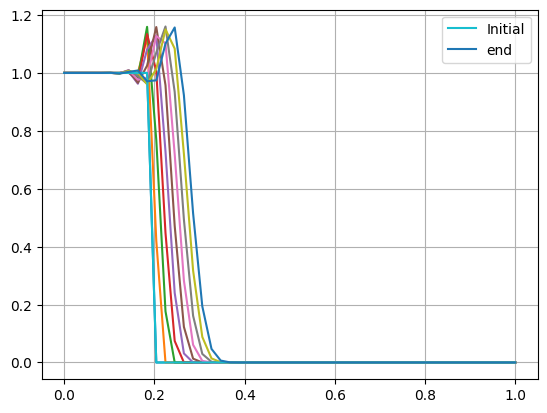

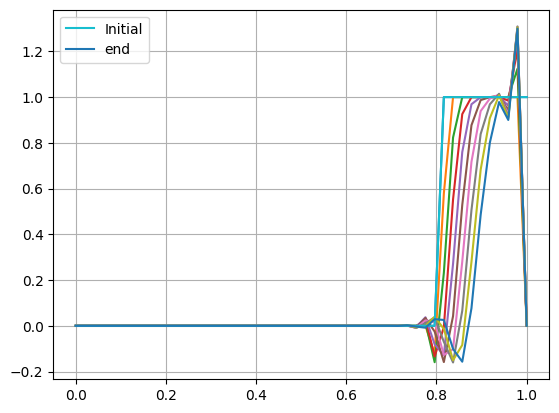

In [193]:
def LaxWendroff(u0, mu, x, t, a):
    N = len(x)
    M = len(t)
    h = x[1] - x[0]
    tau = t[1] - t[0]
    C = tau*a/h
    
    U = np.zeros((M, N))
    
    for i in range(N):
        U[0][i] = u0(x[i])
    for j in range(M):
        U[j][0] = mu(x[j])
    
    for j in range(M-1):
        for i in range(1, N-1):
            U[j+1][i] = U[j][i-1]*C*(1+C)/2 + U[j][i]*(1-C**2) - C/2*(1-C)*U[j][i+1]
    return U

T = 1
N = 50
M = 10
h = 1 / N
tau = T / M
x = np.linspace(0, 1, N)
t = np.linspace(0, T, M)
a = 0.1

courant = a * tau / h
print("Courant number: ", courant)

res1 = LaxWendroff(u1, mu0, x, t, a)
res2 = LaxWendroff(u2, mu0, x, t, a)
res3 = LaxWendroff(u3, mu1, x, t, a)
res4 = LaxWendroff(u4, mu0, x, t, a)

init1 = init(u1)
init2 = init(u2)
init3 = init(u3)
init4 = init(u4)

CreateGraph(1, init1, res1)
CreateGraph(2, init2, res2)
CreateGraph(3, init3, res3)
CreateGraph(4, init4, res4)
plt.show()

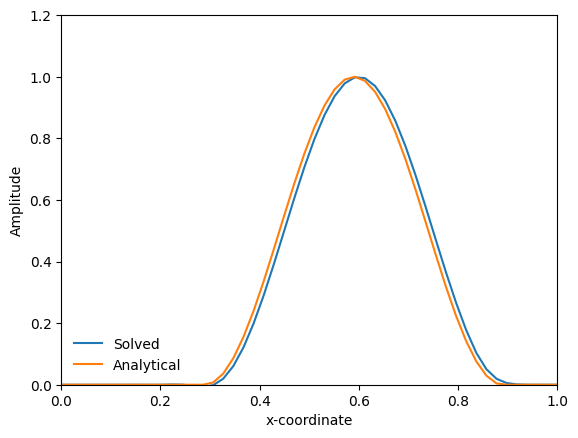

In [196]:
AnimationFunc(u1, res1, "Lax-Wendroff", 10)

## 3.2 Approximation

Order of x approximation =  -1.9814424873020235


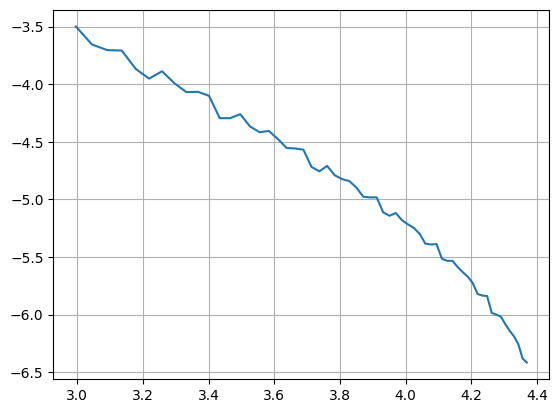

Order of t approximation =  -0.35633590907868834


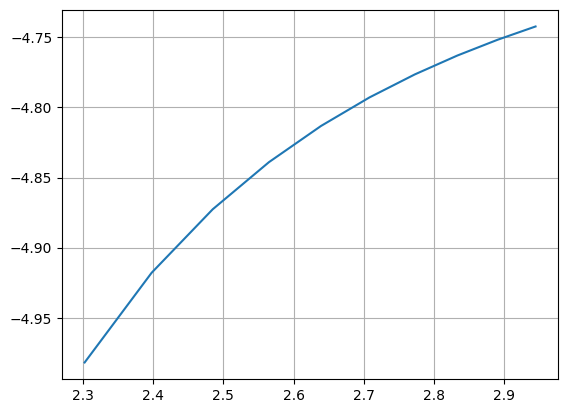

In [197]:
start_range = 20
end_range = 80

plt.figure(1)
index = np.log([i for i in range(start_range, end_range)])
value = np.log([max(np.abs(LaxWendroff(u1, mu0, np.linspace(0, 1, i), np.linspace(0, T, M), a)[-1] -
                        real(u1, np.linspace(0, 1, i), T, a))) for i in range(start_range, end_range)])
a1, b1 = np.polyfit(index, value, 1)
print("Order of x approximation = ", a1)
plt.plot(index, value)
plt.grid()
plt.show()


start_range2 = 10
end_range2 = 20

plt.figure(2)
index = np.log([i for i in range(start_range2, end_range2)])
value = np.log([max(np.abs(LaxWendroff(u1, mu0, np.linspace(0, 1, N), np.linspace(0, T, i), a)[-1] -
                        real(u1, np.linspace(0, 1, N), T, a))) for i in range(start_range2, end_range2)])
a2, b2 = np.polyfit(index, value, 1)
print("Order of t approximation = ", -a2)
plt.plot(index, value)
plt.grid()
plt.show()